In [1]:
#importing packages and identifying/importing csv file

import pandas as pd
import numpy as np
import matplotlib.dates as dates
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
warnings.filterwarnings('ignore')

mts=pd.read_csv('medical_time_series.csv')

In [2]:
# profiling dataframe
mts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [3]:
# indentify duplicate days if any
mts_dup=mts.duplicated()
mts_dup.value_counts()
# all false, no duplicate days

False    731
Name: count, dtype: int64

In [4]:
mts

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


In [5]:
#set day to datetime and select example dates
mts['Day'] = pd.to_datetime(mts['Day'])
mts['Day'] = pd.date_range(start="2000-01-01",end="2001-12-31")

# rename columns 
mts.columns = ['date', 'revenue']
# set date column as new index
mts.set_index('date', inplace=True)
mts

,revenue
date,
2000-01-01,0.000000
2000-01-02,-0.292356
2000-01-03,-0.327772
2000-01-04,-0.339987
2000-01-05,-0.124888
...,...
2001-12-27,15.722056
2001-12-28,15.865822
2001-12-29,15.708988


In [6]:
mts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2000-01-01 to 2001-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


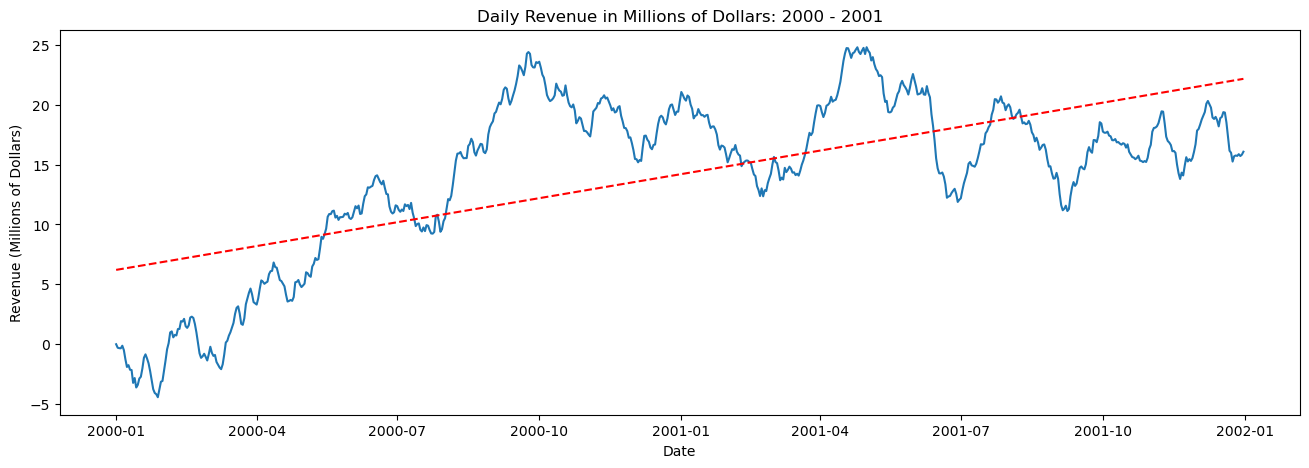

In [7]:
#plot graph with trend line
plt.figure(figsize = [16,5])
# Prettify the graph
plt.title("Daily Revenue in Millions of Dollars: 2000 - 2001")
plt.xlabel('Date')
plt.ylabel('Revenue (Millions of Dollars)')

# plot data
plt.plot(mts)

# make trend line
x = dates.date2num(mts.index)
y = mts.revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot trendline
plt.plot(x, p(x), "r--")
plt.show()

In [8]:
# augmented dicky fuller for test of stationarity
adf1 = adfuller(mts.revenue)

print(adf1)
# data is not stationary (also can be seen clearly in graph above)

(-2.218319047608944, 0.1996640061506439, 1, 729, {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}, 842.453027617641)


(-17.37477230355706, 5.1132069788403175e-30, 0, 729, {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}, 846.2604386450553)


<Axes: xlabel='date'>

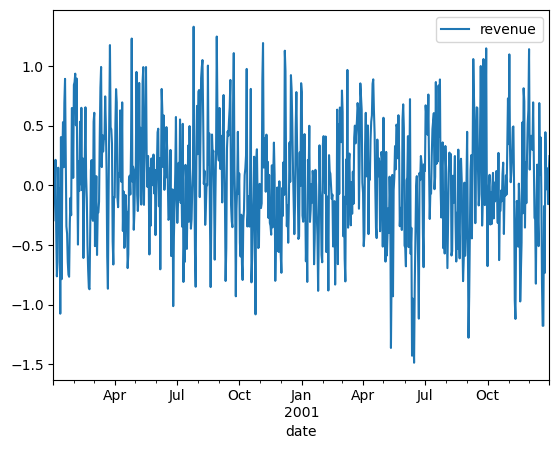

In [9]:
# need to take .diff in order to remove non-stationarity from the data
mts_diff = mts.diff().dropna()

adf2 = adfuller(mts_diff.revenue)

print(adf2)
# extremely small p value, passes stationarity test
mts_diff.plot()
# looks stationary as well

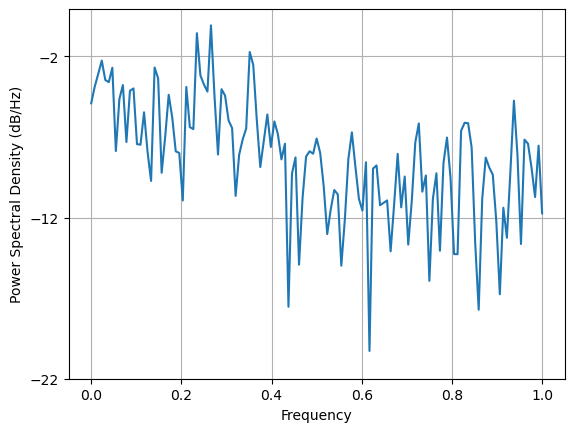

In [10]:
# spectral density plot ofthe differenced data
plt.psd(x=mts_diff.revenue);

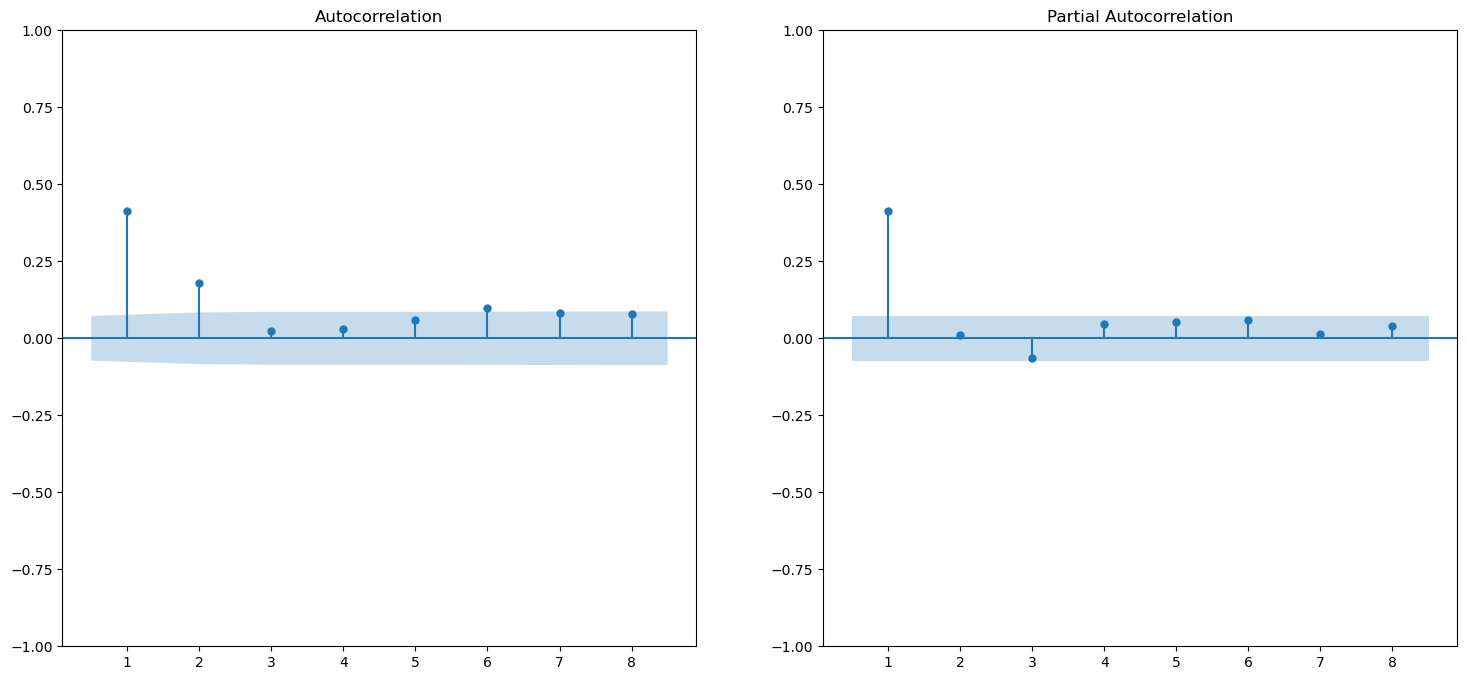

In [11]:
# create subplot for ACF and PACF of the differenced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[18,8])
# use 8 lags for acf and pacf
plot_acf(mts_diff, lags=8, zero=False, ax=ax1)
plot_pacf(mts_diff, lags=8, zero=False,ax=ax2);

# can see that based on these, the model should have an order of (1,0,0)

In [12]:
# split into train and test 
train, test = train_test_split(mts, test_size=0.2, shuffle=False)
train
#confirmed that the train set contains 80% of the data

,revenue
date,
2000-01-01,0.000000
2000-01-02,-0.292356
2000-01-03,-0.327772
2000-01-04,-0.339987
2000-01-05,-0.124888
...,...
2001-08-02,19.782635
2001-08-03,19.088265
2001-08-04,18.805501


In [13]:
test
#confirmation that the test dataset picks up at the end of train and goes to the end of 2001

,revenue
date,
2001-08-07,19.312734
2001-08-08,19.576725
2001-08-09,18.988035
2001-08-10,18.437608
2001-08-11,18.519085
...,...
2001-12-27,15.722056
2001-12-28,15.865822
2001-12-29,15.708988


In [14]:
# save out train and test data
train.to_csv('medical_train.csv')
test.to_csv('medical_test.csv')

Go back to original without the difference and examine the seasonal component
PART D1 

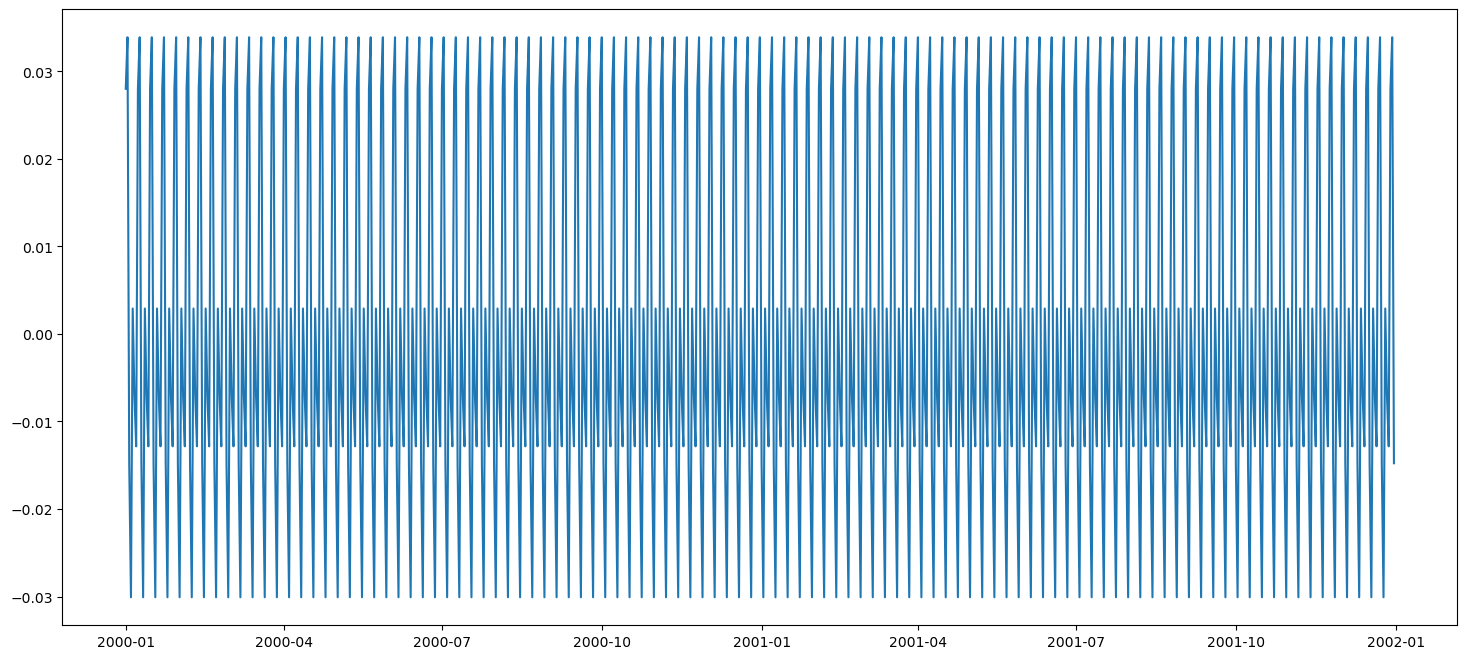

In [15]:
# look at seasonality of the original dataset
mts_decomp = seasonal_decompose(mts)
plt.figure(figsize = [18,8])
# Plot seasonal component of the data
plt.plot(mts_decomp.seasonal);

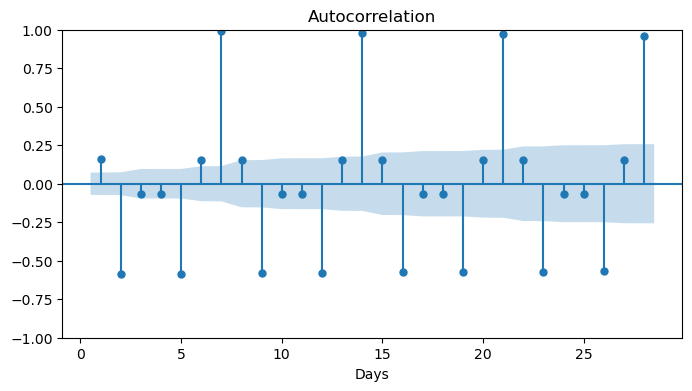

In [16]:
# look at acf lags to determine how often the seasonality repeats
fig,ax = plt.subplots(1,1,figsize=(8,4))

plot_acf(mts_decomp.seasonal, ax=ax, lags=28, zero=False)
plt.xlabel('Days')
plt.show()
# weekly (every 7 days) seasonal component is identified in the acf below

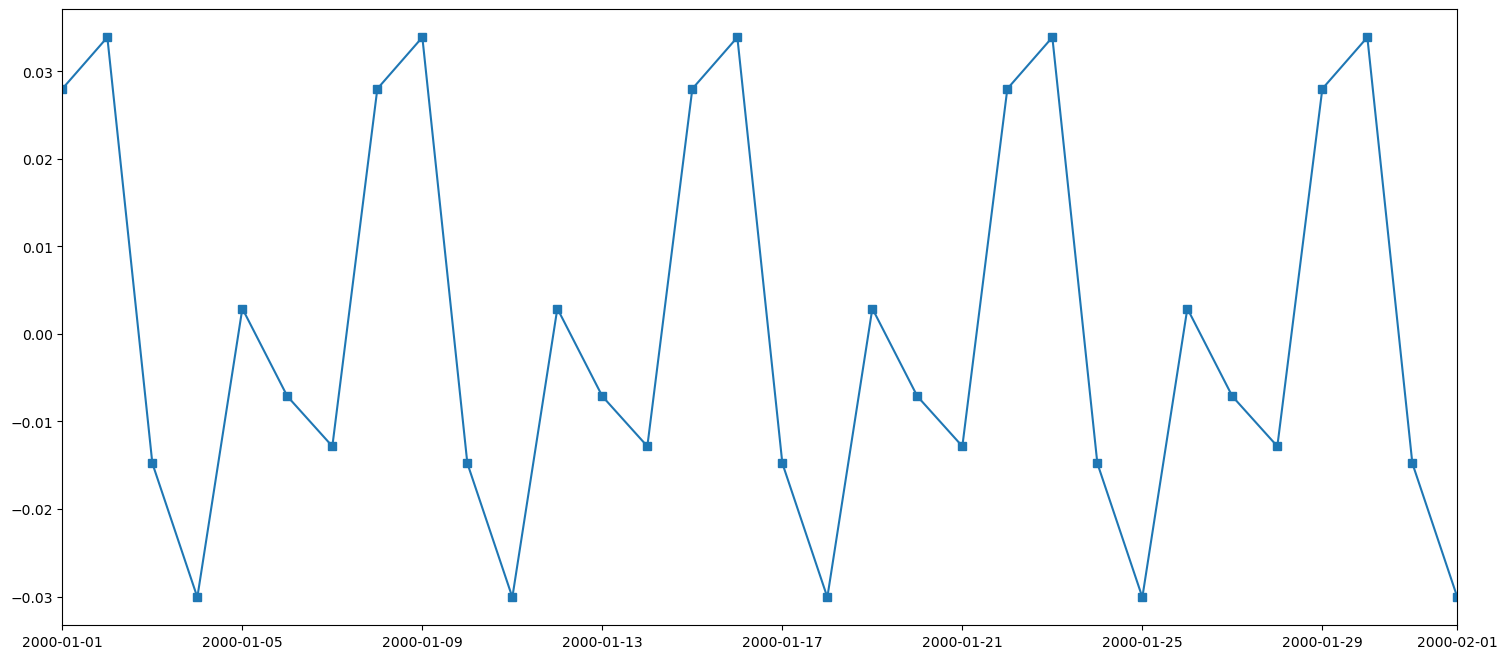

In [17]:
plt.figure(figsize = [18,8])
# plot seasonal component with square marker
plt.plot(mts_decomp.seasonal, marker='s')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-02-01'));
# can see how it repeats every week based on the one month cut out

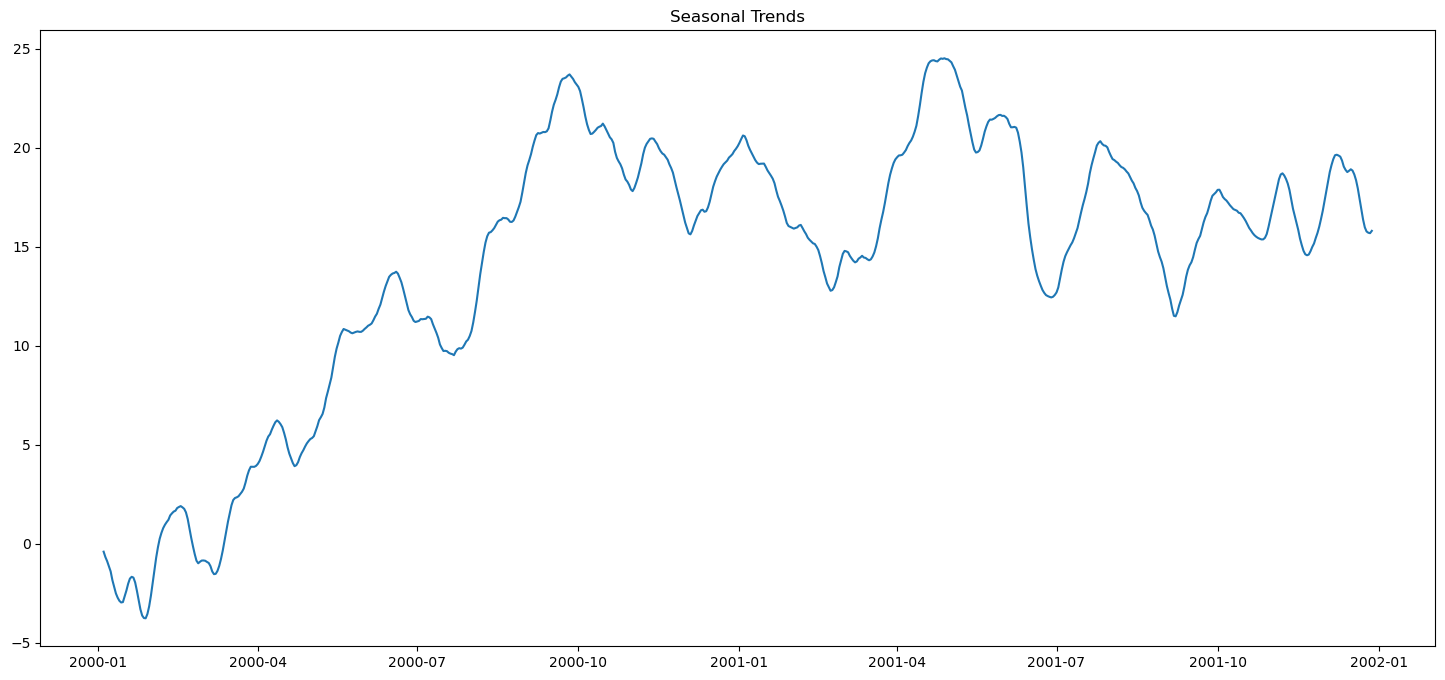

In [18]:
# plot entire decomposed graph
plt.figure(figsize = [18,8])
# Plot trend component of the data
plt.plot(mts_decomp.trend)
plt.title('Seasonal Trends');

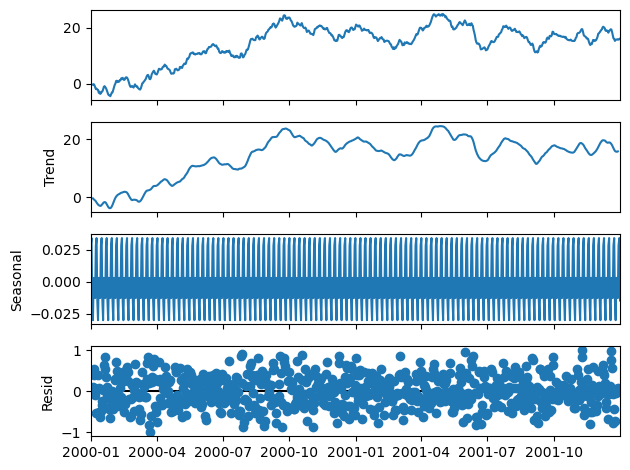

In [19]:
# all plots for decomposed time series
mts_decomp.plot();

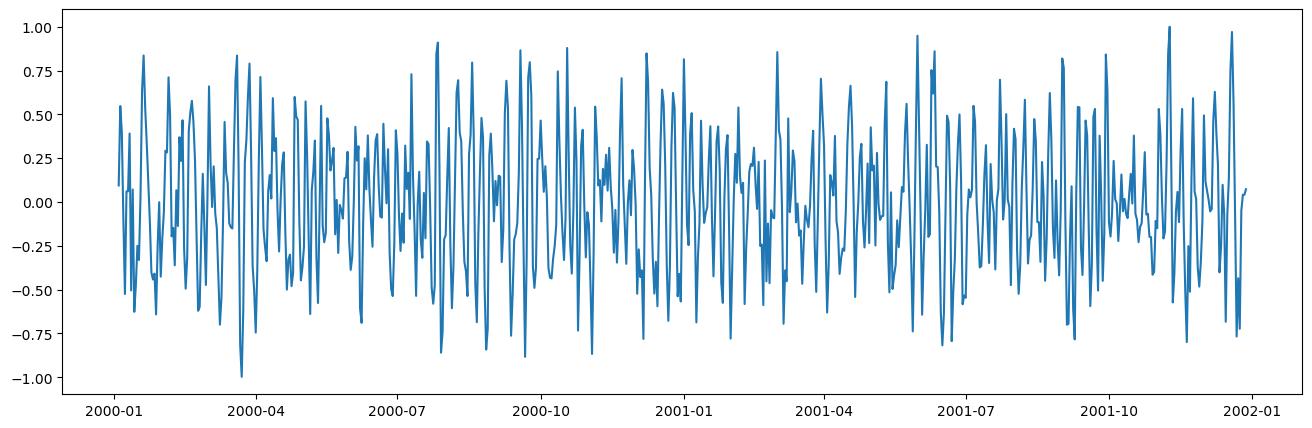

In [20]:
# confirmation of lack of trends in residual data
plt.figure(figsize = [16,5])
# Plot residual component of the data
plt.plot(mts_decomp.resid);

Go back to mts_diff dataframe and use the seasonal information found to do an auto arima

In [21]:
mts_diff_arima=auto_arima(mts_diff['revenue'], trace=True, seasonal=True)

mts_diff_arima.summary()
#even though there is a weekly seasonal component, the auto_arima shows the model performs better without it

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1015.481, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=879.982, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=881.911, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=881.927, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=905.166, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=881.947, Time=0.21 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.428 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -437.991
Date:                Sun, 09 Feb 2025   AIC                            879.982
Time:                        08:11:51   BIC                            889.168
Sample:                    01-02-2000   HQIC                           883.526
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Go back to training data and fit data to SARIMAX model with the numbers from the diff data

In [22]:
# fit sarimax model with info that was measured earlier with the differenced data
# because the prior data was differenced, the updated order for this needs to be (1,1,0) to include differencing
# using this order drops the AIC from 821 down to 706 indicating a better fit
model=SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0))

model_results=model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  584
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -350.812
Date:                Sun, 09 Feb 2025   AIC                            705.625
Time:                        08:11:51   BIC                            714.361
Sample:                    01-01-2000   HQIC                           709.030
                         - 08-06-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.837      0.000       0.336       0.485
sigma2         0.1950      0.012     15.888      0.000       0.171       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.70   Prob(JB):                         0.39
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# forecast using the trained model against the testing data
# using 147 steps to forecast so that the data aligns with the testing data
forecast=model_results.get_forecast(steps = 147)
mean_forecast=forecast.predicted_mean
conf_intervals=forecast.conf_int()
lower_limits=conf_intervals.loc[:,'lower revenue']
upper_limits=conf_intervals.loc[:,'upper revenue']

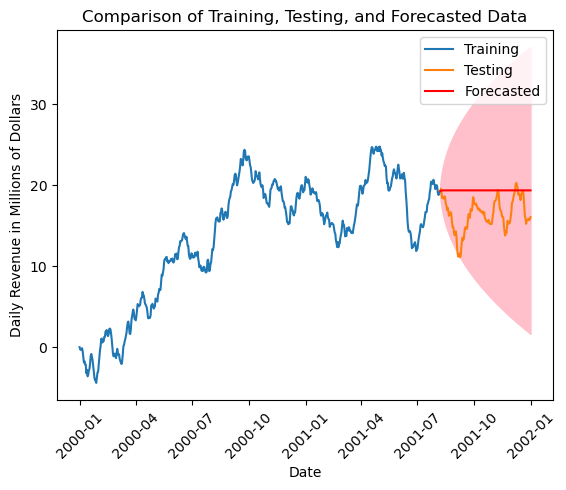

In [24]:
# plot testing/training data against forecasted data
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(mean_forecast, color = 'r', label='Forecast')
# plot the confidence intervals
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.legend(['Training', 'Testing', 'Forecasted'])
plt.title("Comparison of Training, Testing, and Forecasted Data")
plt.xlabel("Date")
plt.ylabel("Daily Revenue in Millions of Dollars")
plt.xticks(rotation=45)
plt.show()

In [25]:
# run rmse here to test model predictions against actual testing data
rmse = mean_squared_error(test, mean_forecast, squared=False)
print(f"RMSE of forecasting model is {round(rmse, 5)}")

RMSE of forecasting model is 3.56082


Fit the entire original dataset with the SARIMAX model

In [26]:
# fit sarimax model with info that was measured earlier with the differenced data
# because the prior data was differenced, the updated order for this needs to be (1,1,0) to include differencing
# using this order drops the AIC from 1025 down to 880 indicating a better fit
final_model=SARIMAX(mts, order=(1,1,0), seasonal_order=(0,0,0,0))

final_model_results=final_model.fit()
final_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Sun, 09 Feb 2025   AIC                            879.982
Time:                        08:11:52   BIC                            889.168
Sample:                    01-01-2000   HQIC                           883.526
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecast the data using the non-stationary data

PART D3 & D4

In [27]:
# forecast using the trained model on the original dataset
# using 60 steps to forecast
final_forecast=final_model_results.get_forecast(steps = 60)
final_mean_forecast=final_forecast.predicted_mean
final_conf_intervals=final_forecast.conf_int()
final_lower_limits=final_conf_intervals.loc[:,'lower revenue']
final_upper_limits=final_conf_intervals.loc[:,'upper revenue']
final_mean_forecast.head(15)
# shows very steady numbers which eventually flatten out and stagnate around day 14

2002-01-01    16.171559
2002-01-02    16.213862
2002-01-03    16.231384
2002-01-04    16.238642
2002-01-05    16.241649
2002-01-06    16.242894
2002-01-07    16.243410
2002-01-08    16.243623
2002-01-09    16.243712
2002-01-10    16.243749
2002-01-11    16.243764
2002-01-12    16.243770
2002-01-13    16.243773
2002-01-14    16.243774
2002-01-15    16.243774
Freq: D, Name: predicted_mean, dtype: float64

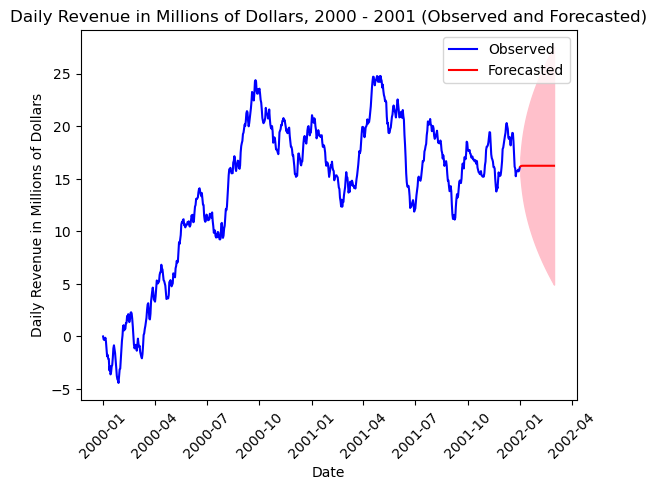

In [28]:
# plot observed data
plt.plot(mts, color = 'blue', label='Observed')
# plot the forecasted data
plt.plot(final_mean_forecast, color = 'r', label='Forecast')
# Plot the confidence intervals
plt.fill_between(final_lower_limits.index, final_lower_limits, final_upper_limits, color = 'pink')
# add legend
plt.legend(['Observed', 'Forecasted'])
plt.title("Daily Revenue in Millions of Dollars, 2000 - 2001 (Observed and Forecasted)")
plt.xlabel("Date")
plt.ylabel("Daily Revenue in Millions of Dollars")
plt.xticks(rotation=45)
plt.show()